In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb

from mlxtend.classifier import StackingClassifier

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from timeit import default_timer as timer
from os.path import exists
import itertools

from bayes_opt import BayesianOptimization

# Make sure you have a folder /Models in your running location.

In [2]:
data = pd.read_csv('Data/adult.data', header=None, skipinitialspace=True)
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',\
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',\
                'native-country', 'income']

data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data.shape

(32561, 15)

In [4]:
# Missing values are denoted as '?' in the data.
# We can see there are a few columns that are missing data.
# I am going to try two different approaches for dealing with this later on.
data.replace('?', np.nan, inplace=True)
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

# What does the data look like and how do we want it to look?

Age -- Continuous, no missing values

Workclass -- Categorical, what sector is their employment in.  A few missing values, but we can probably bucketize this.

fnlweight -- Continuous, this mertic explains how common the line item is for the nation.  I think this should be removed, but will test both.

Education -- Categorical, will remove and use Education-Num.

Education-Num -- Continuous, same info as education.

Marital-Status -- Categorical, no missing values.

Occupation -- Categorical, some missing values.  This is going to be a lot of unique values, I think this will be punted and workclass used.

Relationship -- Categorical, may look to reduce dimenstionality for this one.

Race -- Categorical, pretty concentrated, will probably dum-ify these.

Sex -- Categorical, two options

Capital-gain -- Continuous, mostly 0, we can possibly change this to be a bool if greater than zero.

Capital-loss -- Continuous, mostly 0, we can possibly change this to be a bool if greater than zero.

Hours-per-week -- Continuous

Native-country -- Categorical, missing a few values.  Mostly concentraded as US, will summarize.

Income -- Categorical, target value, what we are trying to predict.

### Workclass

In [5]:
# I suspect there is a good chunk of overlap here.
data['workclass'].value_counts(normalize=True, dropna=False)

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
NaN                 0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64

In [6]:
# We will need to dummy this, but this will control some of the dimensionality.
### NOTE: We are overwriting the NAN's and setting them to 3 (other) we should make note of this for when we test.
gov_jobs = ['Local-gov', 'State-gov', 'Federal-gov']
self_emp_jobs = ['Self-emp-not-inc', 'Self-emp-inc']

data['workclass-cat'] = 3
data.loc[data['workclass'].isin(self_emp_jobs), 'workclass-cat'] = 2
data.loc[data['workclass'].isin(gov_jobs), 'workclass-cat'] = 1
data.loc[data['workclass'] == 'Private', 'workclass-cat'] = 0

data['workclass-cat'].value_counts(normalize=True)

0    0.697030
1    0.133626
2    0.112312
3    0.057031
Name: workclass-cat, dtype: float64

### Education and Education Num

In [7]:
# Quick look at education, we can boot this.  Education-Num is inclusive enough.
data[['education', 'education-num']].groupby('education').mean()

,education-num
education,
10th,6
11th,7
12th,8
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
Assoc-acdm,12
Assoc-voc,11


### Marital Status

In [8]:
data['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

In [9]:
data['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

### Race and Native Country

In [10]:
# We can honestly make this into 'White', 'Black', 'Other'
data['race'].value_counts(normalize=True)

data['race-cat'] = 2
data.loc[data['race'] == 'Black', 'race-cat'] = 1
data.loc[data['race'] == 'White', 'race-cat'] = 0

In [11]:
data['native-country'].value_counts(normalize=True).head(5)

United-States    0.912190
Mexico           0.020108
Philippines      0.006192
Germany          0.004284
Canada           0.003784
Name: native-country, dtype: float64

In [12]:
# Since a vast majority come from the US, and everything else is less than 2%, lets make a new column that is US Bool
data['from-US'] = 0
data.loc[data['native-country'] == 'United-States', 'from-US'] = 1
data['from-US'].astype('object')
data['from-US'].value_counts(normalize=True)

1    0.895857
0    0.104143
Name: from-US, dtype: float64

### Sex

In [13]:
# We should convert sex from string to binary.  Easy enough.
data['sex'] = data['sex'].map({'Male':1,'Female':0}).astype(object)
data['sex'].value_counts(normalize=True)

1    0.669205
0    0.330795
Name: sex, dtype: float64

### Capitol Gain and Loss

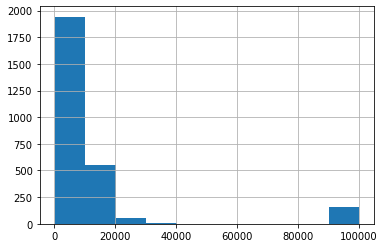

In [14]:
data.loc[data['capital-gain'] > 0, 'capital-gain'].hist()

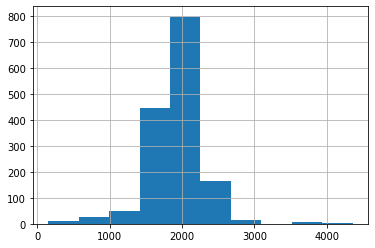

In [15]:
data.loc[data['capital-loss'] > 0, 'capital-loss'].hist()

# A Couple Graphs to Demonstrate Relationships

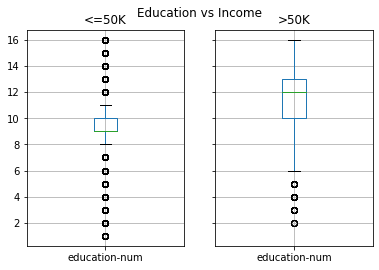

In [16]:
income_by_education = data[['income', 'education-num']].groupby('income')
income_by_education.boxplot()
plt.suptitle('Education vs Income')
plt.show()
# Not surprisingly, we can see that those who make >50k a year have more years of education
# I kinda want to expand this a bit

[Text(0.5, 1.0, 'CDF Income vs Age')]

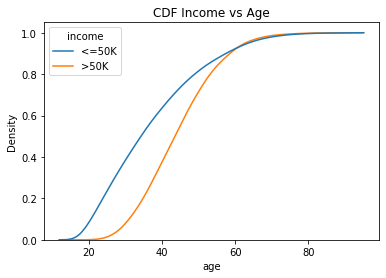

In [17]:
sns.kdeplot(data=data[['age','income']], x='age', hue='income',\
            cumulative=True, common_norm=False, common_grid=True).set(title='CDF Income vs Age')
# There is a big age gap here, which is also intuitive.
# People are not going to make more than 50k in their early years of productivity.

[Text(0.5, 1.0, 'CDF Income vs Hours Worked Per Week')]

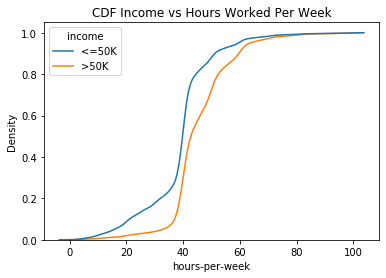

In [18]:
sns.kdeplot(data=data[['hours-per-week','income']], x='hours-per-week', hue='income',\
            cumulative=True, common_norm=False, common_grid=True).set(title='CDF Income vs Hours Worked Per Week')
# This is also intuitive, those who make more than 50k a year end up working more hours on average

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 18 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
workclass-cat     32561 non-null int64
race-cat          32561 non-null int64
from-US           32561 non-null int64
dtypes: int64(9), object(9)
memory usage: 4.5+ MB


In [20]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-cat,race-cat,from-US
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,<=50K,1,0,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,<=50K,2,0,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,<=50K,0,0,1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,<=50K,0,1,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,<=50K,0,1,0


# Summary Before We Start Modeling

Columns to remove:
    - workclass, fnlwgt, education, occupation, race, capital-gain, capital-loss
    
Columns to dummy:
    - marital-status, relationship, race-cat, workclass-cat, race-cat
    
Things to modify:
    - change income to 1 if '>50K', else 0

In [21]:
cols_to_drop = ['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'native-country']
cols_to_dummy = ['marital-status', 'relationship', 'race-cat', 'workclass-cat']

data['income'] = data['income'].map({'>50K':1,'<=50K':0}).astype(int)
data.drop(cols_to_drop, inplace=True, axis=1)

data.head()

,age,education-num,marital-status,relationship,sex,capital-gain,capital-loss,hours-per-week,income,workclass-cat,race-cat,from-US
0,39,13,Never-married,Not-in-family,1,2174,0,40,0,1,0,1
1,50,13,Married-civ-spouse,Husband,1,0,0,13,0,2,0,1
2,38,9,Divorced,Not-in-family,1,0,0,40,0,0,0,1
3,53,7,Married-civ-spouse,Husband,1,0,0,40,0,0,1,1
4,28,13,Married-civ-spouse,Wife,0,0,0,40,0,0,1,0


In [22]:
dummies = pd.get_dummies(data[cols_to_dummy])
data[dummies.columns] = dummies
data.drop(cols_to_dummy, inplace=True, axis=1)
data.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income,from-US,marital-status_Divorced,marital-status_Married-AF-spouse,...,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,39,13,1,2174,0,40,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,50,13,1,0,0,13,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,38,9,1,0,0,40,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,53,7,1,0,0,40,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,28,13,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Functions

In [23]:
def load_and_process_data() -> pd.DataFrame:
    data = pd.read_csv('Data/adult.data', header=None, skipinitialspace=True)
    data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',\
                    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',\
                    'native-country', 'income']
    
    # Change the missing value (?) to something we can work with.
    data.replace('?', np.nan, inplace=True)
    
    # We are going to bucketize the workclass
    gov_jobs = ['Local-gov', 'State-gov', 'Federal-gov']
    self_emp_jobs = ['Self-emp-not-inc', 'Self-emp-inc']

    data['workclass-cat'] = 3
    data.loc[data['workclass'].isin(self_emp_jobs), 'workclass-cat'] = 2
    data.loc[data['workclass'].isin(gov_jobs), 'workclass-cat'] = 1
    data.loc[data['workclass'] == 'Private', 'workclass-cat'] = 0
    
    # We are going to bucketize the races
    data['race-cat'] = 2
    data.loc[data['race'] == 'Black', 'race-cat'] = 1
    data.loc[data['race'] == 'White', 'race-cat'] = 0
    
    # And where everyone is from
    data['from-US'] = 0
    data.loc[data['native-country'] == 'United-States', 'from-US'] = 1
    
    # Map male and female to numerical
    data['sex'] = data['sex'].map({'Male':1,'Female':0})
    
    # Map the target column
    data['income'] = data['income'].map({'>50K':1,'<=50K':0})
    
    cols_to_drop = ['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'native-country']    
    data.drop(cols_to_drop, axis=1, inplace=True)
    
    return data

def save_model(model, name):
    with open(f'Models/{name}.pkl', 'wb') as fid:
        pickle.dump(model, fid)  
        
def load_model(name):
    with open(f'Models/{name}.pkl', 'rb') as fid:
        model = pickle.load(fid)
    return model

# Lets Make a Model

In [24]:
data = load_and_process_data()

TGT_COL = ['income']
NUM_COL = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
CAT_COL = ['marital-status', 'relationship', 'race-cat', 'workclass-cat']

for cc in CAT_COL:
    data[cc] = data[cc].astype('object')

dummies = pd.get_dummies(data[CAT_COL]) # Get Dummies only works on categorical columns!
data = pd.concat([data, dummies], axis=1)
data.drop(CAT_COL, inplace=True, axis=1)
  
X = data.drop('income', axis=1)
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

ss = StandardScaler()

sc_num_cols = pd.DataFrame(ss.fit_transform(X_train[NUM_COL]),
                           columns=['sc_' + str(w) for w in NUM_COL])
X_train = pd.concat([X_train, sc_num_cols], axis=1)

sc_num_cols = pd.DataFrame(ss.transform(X_test[NUM_COL]), 
                           columns=['sc_' + str(w) for w in NUM_COL])
X_test = pd.concat([X_test, sc_num_cols], axis=1)

In [25]:
X_train.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,from-US,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,...,race-cat_2,workclass-cat_0,workclass-cat_1,workclass-cat_2,workclass-cat_3,sc_age,sc_education-num,sc_hours-per-week,sc_capital-gain,sc_capital-loss
0,43,7,1,0,0,60,1,0,0,1,...,0,0,0,1,0,0.323996,-1.187429,1.572934,-0.146047,-0.215155
1,18,10,0,0,1602,20,1,0,0,0,...,0,0,0,0,1,-1.510030,-0.028839,-1.648494,-0.146047,3.775441
2,34,10,0,0,0,40,1,0,0,0,...,0,1,0,0,0,-0.336253,-0.028839,-0.037780,-0.146047,-0.215155
3,17,6,0,0,0,12,1,0,0,0,...,0,1,0,0,0,-1.583391,-1.573625,-2.292780,-0.146047,-0.215155
4,41,10,0,0,0,36,1,1,0,0,...,0,1,0,0,0,0.177274,-0.028839,-0.359923,-0.146047,-0.215155


In [26]:
#X_train.columns
data = load_and_process_data()

TGT_COL = ['income']
NUM_COL = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
CAT_COL = ['marital-status', 'relationship', 'race-cat', 'workclass-cat']

dummies = pd.get_dummies(data[CAT_COL])

# KNN

In [27]:
neighbor_count = range(1,26)
train_acc = []
test_acc = []

for nc in tqdm(neighbor_count):
    knn = KNeighborsClassifier(n_neighbors=nc)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

100%|██████████| 25/25 [02:57<00:00,  7.11s/it]


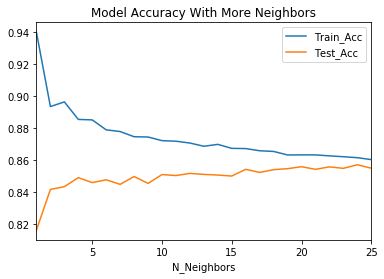

In [28]:
knn_results = pd.DataFrame({
    'N_Neighbors' : list(neighbor_count),
    'Train_Acc' : train_acc,
    'Test_Acc' : test_acc
})

knn_results.plot(x='N_Neighbors', title='Model Accuracy With More Neighbors')

In [29]:
if exists('Models/knn_cv.pkl'):
    knn_cv = load_model('knn_cv')
else: 
    param_grid = {
        'n_neighbors' : neighbor_count
    }

    knn = KNeighborsClassifier()
    knn_cv = GridSearchCV(knn, param_grid, cv=5)
    knn_cv.fit(X_train, y_train)
    save_model(knn_cv,'knn_cv')
    
print(f"Tuned Logistic Regression Parameters: {knn_cv.best_params_}.")
print(f"Best score is {knn_cv.best_score_}.")

Tuned Logistic Regression Parameters: {'n_neighbors': 12}.
Best score is 0.8492453492453492.


# Logistic Regression

In [30]:
c_range = np.logspace(-5, 8, 15)
train_acc = []
test_acc = []

for c in tqdm(c_range):
    lr = LogisticRegression(C = c, solver='lbfgs')
    lr.fit(X_train, y_train)
    train_acc.append(lr.score(X_train, y_train))
    test_acc.append(lr.score(X_test, y_test))

  0%|          | 0/15 [00:00<?, ?it/s]/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
  7%|▋         | 1/15 [00:00<00:03,  3.52it/s]/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 13%|█▎        | 2/15 [00:00<00:03,  3.55it/s]/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 20%|██        | 3/15 [00:00<00:03,  3.82it/s]/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the nu

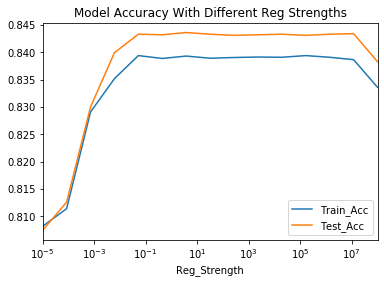

In [31]:
lr_results = pd.DataFrame({
    'Reg_Strength' : list(c_range),
    'Train_Acc' : train_acc,
    'Test_Acc' : test_acc
})

lr_results.plot(x='Reg_Strength', logx=True, title='Model Accuracy With Different Reg Strengths')

In [32]:
if exists('Models/lr_cv.pkl'):
    lr_cv = load_model('lr_cv')
else:
    param_grid = {
        'C' : c_range
    }

    lr = LogisticRegression(solver='lbfgs', max_iter=150)
    lr_cv = GridSearchCV(lr, param_grid, cv=5)
    lr_cv.fit(X_train, y_train)
    save_model(lr_cv,'lr_cv')
    
print(f"Tuned Logistic Regression Parameters: {lr_cv.best_params_}.")
print(f"Best score is {lr_cv.best_score_}.")

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarni

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarni

Tuned Logistic Regression Parameters: {'C': 31.622776601683793}.
Best score is 0.8417865917865918.


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Quick Detour to Model Importance

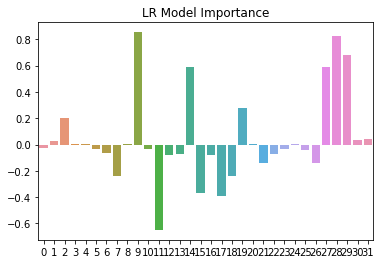

In [33]:
importance = lr_cv.best_estimator_.coef_[0]
importance_index = list(range(len(importance)))
sns.barplot(x=importance_index, y=importance).set(title='LR Model Importance')
plt.show()

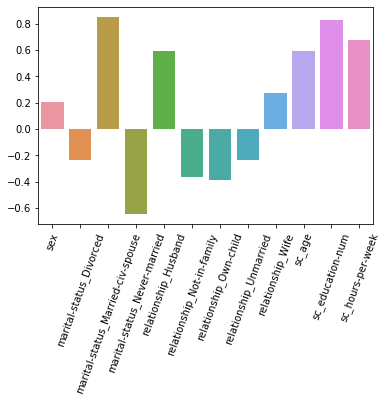

In [34]:
# Lets look at anything that has a coefficient of > 0.2
importance_mask = np.abs(importance) > 0.2
v_importance = importance[importance_mask]
v_importance_names = X_train.columns[importance_mask]
sns.barplot(x=v_importance_names, y=v_importance)
plt.xticks(rotation=70)
plt.show()

Lets see what we can get out of this:

Benefit:
- Married with spouse
- Being a husband
- Being older
- More years of education
- More hours per week

Detractor:
- Never being married
- Not in a family
- Having a child

I find it very interesting that being a husband is important, but being male is not.

In [35]:
importance[X_train.columns == 'sex']
# Ah, so it is in there, and preferences males, but it was just a tad below the threshold I had decided above.

array([0.20418188])

In [36]:
pca = PCA()
pc = pca.fit_transform(X_train)
pca.explained_variance_ratio_.cumsum()
# Wow, so 99.6% of the variance can be explained by one variable?  Thats crazy.

array([0.99697106, 0.99999345, 0.99999697, 0.99999982, 0.99999996,
       0.99999997, 0.99999997, 0.99999998, 0.99999998, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

# Decision Tree

In [37]:
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1,10),
    'min_samples_split' : range(2,11),
    'min_samples_leaf' : range(1,5)
}

dc = DecisionTreeClassifier()
dc_cv = RandomizedSearchCV(dc, param_grid, cv=5, n_iter=20, scoring='accuracy')

start = timer()
dc_cv.fit(X_train, y_train)
end = timer()

print(f"Best decision tree random grid search parameters: {dc_cv.best_params_}.")
print(f"Best score is {dc_cv.best_score_}.")
print(f"This took {end-start} seconds.")

Best decision tree random grid search parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'entropy'}.
Best score is 0.8547736047736048.
This took 3.6340455280000015 seconds.


In [38]:
# This was actually really fast.  
# For giggles, lets see how long it takes to do the whole grid and see what the gain is

if exists('Models/dc_cv.pkl'):
    dc_cv = load_model('dc_cv')
else:
    dc_cv = GridSearchCV(dc, param_grid, cv=5)

    start = timer()
    dc_cv.fit(X_train, y_train)
    end = timer()
    print(f"This took {end-start} seconds.")
    save_model(dc_cv,'dc_cv')

print(f"Best decision tree grid search parameters: {dc_cv.best_params_}.")
print(f"Best score is {dc_cv.best_score_}.")

This took 102.331384109 seconds.
Best decision tree grid search parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 10}.
Best score is 0.85508073008073.


# Neural Networks #1

In [39]:
# Lets do one quick one to make sure everything is working as planned with default parameters.
nn = MLPClassifier(learning_rate='adaptive', solver='adam', alpha=0.1) 
nn.fit(X_train, y_train)
nn.score(X_test, y_test)

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8516736615825571

In [40]:
if exists('Models/nn_cv.pkl'):
    nn_cv = load_model('nn_cv')
else:
    nn = MLPClassifier(learning_rate='adaptive', max_iter=300)
    param_grid = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.01, 0.1],
    }

    nn_cv = RandomizedSearchCV(nn, param_grid, cv=5, scoring='accuracy', n_iter=10)

    start = timer()
    nn_cv.fit(X_train, y_train)
    end = timer()
    print(f"This took {end-start} seconds.")
    save_model(nn_cv, 'nn_cv')

print(f"Best sklearn neural network grid search parameters: {nn_cv.best_params_}.")
print(f"Best score is {nn_cv.best_score_}.")

#{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'tanh'}
#Best score is 0.8513513513513513.
#This took 1847.9064502009999 seconds.

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) re

This took 515.651046049 seconds.
Best sklearn neural network grid search parameters: {'solver': 'adam', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.01, 'activation': 'relu'}.
Best score is 0.8406897156897157.


# Lets do some more voting

In [41]:
models = [
    ('knn', knn_cv.best_estimator_),
    ('lr', lr_cv.best_estimator_),
    ('dc', dc_cv.best_estimator_),
    ('nn', nn_cv.best_estimator_)
]

for i in range(2,len(models)+1):
    for m in itertools.combinations(models, i):
        models_being_looked_at = ', '.join([j[0] for j in m])
        vc = VotingClassifier(m, voting='soft')
        vc.fit(X_train, y_train)
        print(f'Voting using: {models_being_looked_at} yielded an accuracy of {vc.score(X_test, y_test)}')

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: knn, lr yielded an accuracy of 0.8610912068789026
Voting using: knn, dc yielded an accuracy of 0.8602722898966118
Voting using: knn, nn yielded an accuracy of 0.8618077592384072


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: lr, dc yielded an accuracy of 0.8569966219674481


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: lr, nn yielded an accuracy of 0.8518783908281298
Voting using: dc, nn yielded an accuracy of 0.8601699252738254


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: knn, lr, dc yielded an accuracy of 0.8633432285802027


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: knn, lr, nn yielded an accuracy of 0.8633432285802027
Voting using: knn, dc, nn yielded an accuracy of 0.8648786979219981


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: lr, dc, nn yielded an accuracy of 0.8599651960282526


/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting using: knn, lr, dc, nn yielded an accuracy of 0.8630361347118436


In [42]:
# The best model came from using knn, dc, nn, so lets make a model with that.
best_models = [
    ('knn', knn_cv.best_estimator_),
    ('dc', dc_cv.best_estimator_),
    ('nn', nn_cv.best_estimator_)
]

if exists('Models/best_vc.pkl'):
    best_vc = load_model('best_vc')
else:
    best_vc = VotingClassifier(best_models, voting='soft').fit(X_train, y_train)
    save_model(best_vc, 'best_vc')

# What about Stacking?

https://www.geeksforgeeks.org/stacking-in-machine-learning-2/

Stacking is a way of ensembling classification or regression models it consists of two-layer estimators. The first layer consists of all the baseline models that are used to predict the outputs on the test datasets. The second layer consists of Meta-Classifier or Regressor which takes all the predictions of baseline models as an input and generate new predictions.

In [43]:
if 'vc' not in [i[0] for i in models]:
    models.append(('vc', best_vc))

if exists('Models/lr_stack.pkl'):
    lr_stack = load_model('lr_stack')
else:
    lr_stack = StackingClassifier(classifiers=[c[1] for c in models], 
                                   meta_classifier=LogisticRegression(max_iter=250, solver='lbfgs'), 
                                   use_probas=True, 
                                   use_features_in_secondary=True)
    lr_stack.fit(X_train, y_train)
    save_model(lr_stack, 'lr_stack')
    
if 'stack' not in [i[0] for i in models]:
    models.append(('stack', lr_stack))

print(f'Stacking yielded an accuracy of {lr_stack.score(X_test, y_test)}')

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Stacking yielded an accuracy of 0.8634455932029891


In [44]:
for m in models:
    y_pred = m[1].predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Model {m[0]} has an RMSE of {rmse:.3f} and an accuracy of {accuracy_score(y_test, y_pred)*100:.3f}%.')

Model knn has an RMSE of 0.385 and an accuracy of 85.178%.
Model lr has an RMSE of 0.395 and an accuracy of 84.430%.
Model dc has an RMSE of 0.375 and an accuracy of 85.915%.
Model nn has an RMSE of 0.381 and an accuracy of 85.454%.
Model vc has an RMSE of 0.370 and an accuracy of 86.283%.
Model stack has an RMSE of 0.370 and an accuracy of 86.345%.


# XG Boost

Gradient boosting re-defines boosting as a numerical optimization problem where the objective is to minimize the loss function of the model by adding weak learners using gradient descent. 

In [45]:
xgb_classifier = xgb.XGBClassifier(objective='reg:logistic', max_depth=5, seed=42)
xgb_classifier.fit(X_train, y_train)
xgb_classifier.score(X_test, y_test)

0.8685638243423073

In [46]:
param_grid = {
    'max_depth' : [3, 4, 5],
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [100, 200, 300]
}

if exists('Models/xgb_cv.pkl'):
    xgb_cv = load_model('xgb_cv')
else:
    estimator = xgb.XGBClassifier(objective='reg:logistic')

    xgb_cv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5,
        verbose=True
    )

    xgb_cv.fit(X_train, y_train)
    save_model(xgb_cv, 'xgb_cv')
    
if 'xgb' not in [i[0] for i in models]:
    models.append(('xgb', xgb_cv.best_estimator_))

print(f"Best XG Boost grid search parameters: {xgb_cv.best_params_}.")
print(f"Best score is {xgb_cv.best_score_}.")
print(f'Model has an RMSE of {np.sqrt(mean_squared_error(xgb_cv.best_estimator_.predict(X_test), y_test))}.')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 14.8min finished


Best XG Boost grid search parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}.
Best score is 0.8646454896454896.
Model has an RMSE of 0.3640909041823796.


# XGBoost Feature Importance

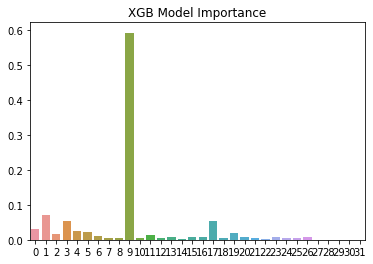

In [47]:
importance = xgb_cv.best_estimator_.feature_importances_
importance_index = list(range(len(importance)))
sns.barplot(x=importance_index, y=importance).set(title='XGB Model Importance')
plt.show()

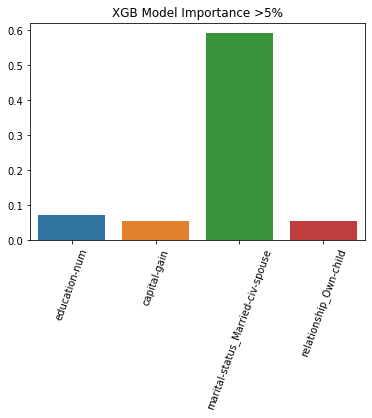

In [48]:
# Lets look at anything that has a coefficient of > 0.05
# This is way more clustered than otherwise.
importance_mask = np.abs(importance) > 0.05
v_importance = importance[importance_mask]
v_importance_names = X_train.columns[importance_mask]
sns.barplot(x=v_importance_names, y=v_importance).set(title='XGB Model Importance >5%')
plt.xticks(rotation=70)
plt.show()

# Bayesian Hyperparameter Tuning

In [49]:
dtrain = xgb.DMatrix(X_train, label=y_train)

def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate):
    params = {
        'max_depth' : int(max_depth),
        'gamma' : gamma,
        'n_estimators' : int(n_estimators),
        'learning_rate' : learning_rate,
        'sub_sample' : 0.8,
        'eta' : 0.1,
        'eval_metric' : 'rmse'
    }
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

xgb_bo = BayesianOptimization(
    bo_tune_xgb,
    {
        'max_depth' : (3,10),
        'gamma' : (0,1),
        'learning_rate' : (0,1),
        'n_estimators' : (100,200)
    }
)

xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

/Users/andrewcoogan/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.3162   |  0.6916   |  0.9704   |  9.315    |  162.3    |
|  2        | -0.3095   |  0.6352   |  0.6678   |  8.485    |  125.2    |
|  3        | -0.3115   |  0.8822   |  0.6547   |  3.609    |  120.3    |
|  4        | -0.3107   |  0.5843   |  0.4866   |  3.222    |  113.3    |
|  5        | -0.3105   |  0.1623   |  0.7805   |  4.956    |  174.0    |
|  6        | -0.4318   |  0.4564   |  0.004006 |  6.626    |  123.4    |
|  7        | -0.3089   |  0.4314   |  0.7467   |  4.644    |  102.4    |
|  8        | -0.3637   |  0.009344 |  0.993    |  8.136    |  151.8    |
|  9        | -0.314    |  1.0      |  1.0      |  10.0     |  200.0    |
|  10       | -0.314    |  1.0      |  1.0      |  10.0     |  135.5    |
|  11       | -0.5      |  1.0      |  0.0      |  3.0      |  190.5    |
|  12       | -0.3882   |  0.0      | 

In [50]:
params = xgb_bo.max['params']
print(params)

{'gamma': 0.43142139525680545, 'learning_rate': 0.7466995756202501, 'max_depth': 4.644043328646595, 'n_estimators': 102.35635564694843}


In [51]:
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])

bae_xgb = xgb.XGBClassifier(**params, objective='reg:logistic').fit(X_train, y_train)

print(f"Accuracy score is {bae_xgb.score(X_test, y_test)}.")
print(f'Model has an RMSE of {np.sqrt(mean_squared_error(bae_xgb.predict(X_test), y_test))}.')

Accuracy score is 0.8650834271675709.
Model has an RMSE of 0.3673099138771361.


# Keras

In [52]:
early_stopping_monitor = EarlyStopping(patience=2)

k_model = Sequential()
k_model.add(Dense(100, activation='relu', input_shape=(X_test.shape[1],)))
k_model.add(Dense(100, activation='relu'))
k_model.add(Dense(1, activation='sigmoid'))
k_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
k_model.fit(X_train, y_train, epochs=5)#, callbacks=[early_stopping_monitor])
k_model.evaluate(X_test, y_test)

Epoch 1/5
713/713 [==============================] - 1s 760us/step - loss: 12.2246 - accuracy: 0.7543
Epoch 2/5
713/713 [==============================] - 1s 705us/step - loss: 0.5489 - accuracy: 0.7591
Epoch 3/5
713/713 [==============================] - 1s 704us/step - loss: 0.5312 - accuracy: 0.7592
Epoch 4/5
713/713 [==============================] - 1s 702us/step - loss: 0.5220 - accuracy: 0.7591
Epoch 5/5
306/306 [==============================] - 0s 578us/step - loss: 0.5146 - accuracy: 0.7790


[0.5145931839942932, 0.7789947986602783]

pca and scaling: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
feature importance: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
pipeline: https://github.com/datacamp/course-resources-ml-with-experts-budgets/blob/master/notebooks/1.0-full-model.ipynb
kaggle: https://www.kaggle.com/overload10/income-prediction-on-uci-adult-dataset

    